# Opracowanie modelu regresyjnego 

Celem tej części projektu jest opracowanie modelu regresyjnego, który na podstawie posiadanego zbioru (zawierającego zmienne ekonomiczne, społeczne i zdrowotne) będzie przewidywać **oczekiwaną długość życia**.

**Przedmiot:** Metody Eksploracji Danych

**Autorzy:** Stanisław Dutkiewicz, Paweł Myszka, Łukasz Jugo

**Grupa 6**

**Data:** 21 stycznia 2026

**Uwaga! Ze względu na wykorzystanie różnych czasochłonnych funkcji w notatniku czas jego uruchamiania może być spory - nawet ok. 40 minut**

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector

import re

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_theme(style="whitegrid")

# 1. Wczytanie CSV i wstępna analiza zbioru


In [3]:
df = pd.read_csv("Life Expectancy Data.csv")

#usuniecie bialych znakow z poczatku i konca nazw kolumn
df.columns = df.columns.str.strip()

display(df.info())
display(df.head())

cat_cols = df.select_dtypes(include="object").columns
print("\nKolumny kategoryczne:", cat_cols)
for col in cat_cols:
    print("-", col, ":", df[col].nunique(), 'unikalnych wartosci')

print("\nCechy:", list(df.columns))

print("\nPrzykładowe kraje:", pd.Series(df["Country"].unique()).sample(5).values)

print("\nLata:", df["Year"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

None

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5



Kolumny kategoryczne: Index(['Country', 'Status'], dtype='object')
- Country : 193 unikalnych wartosci
- Status : 2 unikalnych wartosci

Cechy: ['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling']

Przykładowe kraje: ["Democratic People's Republic of Korea" 'Republic of Korea' 'India'
 'Saint Vincent and the Grenadines' 'Morocco']

Lata: [2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003 2002
 2001 2000]


## Wnioski ze wstępnej analizy zbioru po wczytaniu danych z pliku **Life Expectancy Data.csv**.


Nazwy cech: 'Measles ',' BMI ', 'under-five deaths ', 'Diphtheria ',' HIV/AIDS', ' thinness  1-19 years', ' thinness 5-9 years' posiadają białe znaki na skrajach, dlatego poprawiamy ich nazwy by się ich pozbyć. 

Przegląd zbioru:

- **posiadamy 21 cech:** 'Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling' (ich znaczenie zostało opisane w poprzednim sprawozdaniu)

- **Posidamy 2 cechy nienumeryczne:** 'Country', które odpowiada za nazwę kraju oraz 'Status', która jest cechą binarną, ponieważ przyjmować może jedynie wartość: 'Developed' lub 'Developing'

- **kraje znajdujące się w zbiorze są z całego świata,** a nie tylko z jednego kontynentu,

- **dane są z lat: od 2000 do 2015.**

- liczba krajów odpowiada liczbie **państw członkowskich ONZ**

# 2. Braki danych

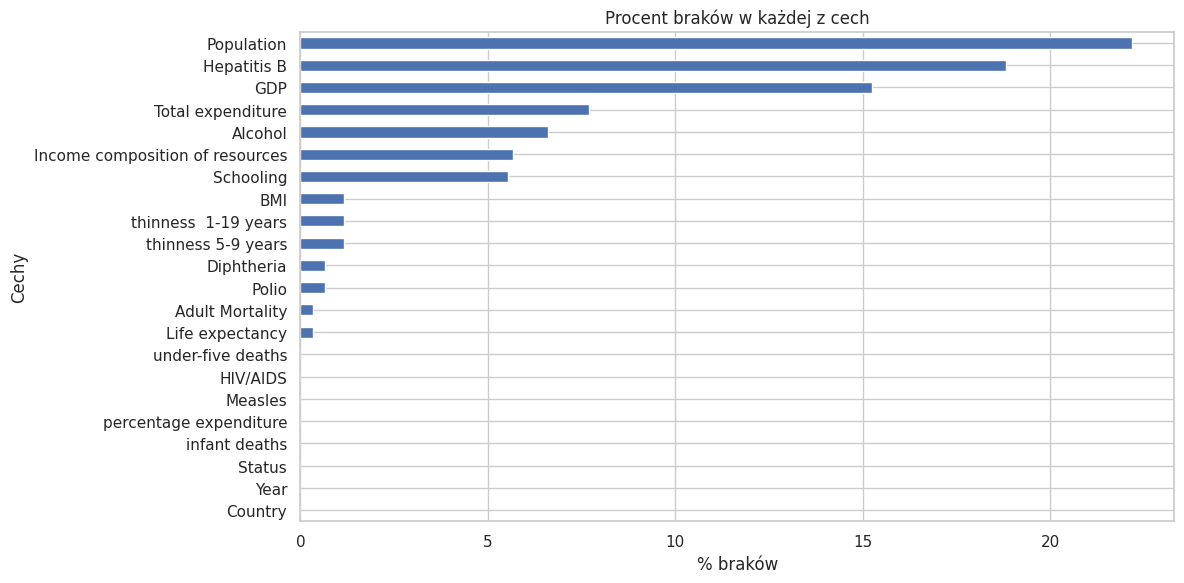

Przed usunieciem:
'Life expectancy' missing %: 0.34
Po usunieciu:
'Life expectancy' missing %: 0.0


In [4]:
missing_pct = df.isna().mean() * 100

plt.figure(figsize=(12, 6))
missing_pct.sort_values(ascending=True).plot(kind='barh',)
plt.xlabel('% braków')
plt.ylabel('Cechy')
plt.title('Procent braków w każdej z cech')
plt.tight_layout()
plt.show()

print('Przed usunieciem:')
print("'Life expectancy' missing %:", round(df["Life expectancy"].isna().mean() * 100, 2))

df_clean = df.dropna(subset=["Life expectancy"])
print('Po usunieciu:')
print("'Life expectancy' missing %:", round(df_clean["Life expectancy"].isna().mean() * 100, 2))

numeric_columns = df_clean.drop(columns=["Country", "Status"]).columns.tolist()

## Braki danych - procentowa analiza

Na podstawie procentowej analizy braków danych w każdej cech określamy:
- największy brak (aż 22.19%) występuje dla populacji
- najmniejszy brak występuje dla naszej zmeiennej objaśnionej Life expectancy - 0,34%.
- cechy kategoryczne nie posiadają braków
- 6 zmiennych mogących potencjalnie wejść w skłąd modelu nie posiada braków

Usunięcie wszystkich wierszy z brakującymi danymi powoduje zbyt dużą stratę informacji(~44%), dlatego usuwamy jedynie wiersze gdzie brakuje naszej kluczowej zmiennej - Life expectancy.

Tak jak zostało wcześniej napisane w eksploracyjnej analizie danych dalsze braki możemy zastąpić na wiele sposobów. My zdecydujemy się na sprawdzenie następujących rozwiązań:
- uzupełnianie w obrębie danego kraju - zastępowanie braku najbliższą znaną wartością (backward fill i forward fill)
- uzupełnianie braków w kolumnach liczbowych za pomocą mediany
- uzupełnianie w obrębie danego kraju za pomocą interpolacji liniowej - wartości których nie ma są obliczane na podstawie innych wartości dla danego kraju, chyba że są to wartości skrajne wówczas uruchamiamy dla nich autouzupełnianie.

## Uzupełnienie kolumny GDP

Problematyczną kwestią w naszym zbiorze danych jest kolumna GDP odpowiadająca PKB per capita danego kraju. Posiada ona ponad 15% braków w swoich kolumnach, których często nie da się sensownie zastąpić. Sytuacja taka ma miejsce, gdy dany kraj posiada tą kolumnę całkowicie pustą. Z tego względu postanowiliśmy podmienić całą kolumnę GDP danymi ze zbioru danych Banku Światowego, który jest o wiele bardziej kompletny. Służy do tego specjalna funkcja `update_life_expectancy_gdp`, która zamienia kolumnę we wczytanym przez nas pliku. Zawiera ona słownik mapujący nazwy krajów, które różnią się pomiędzy dwoma zbiorami.

In [5]:
def update_life_expectancy_gdp(df, gdp_data_path):
    le_df = df.copy()
    gdp_df_wide = pd.read_csv(gdp_data_path, skiprows=4)
    
    le_df.columns = le_df.columns.str.strip()
    
    country_mapping = {
        'Venezuela (Bolivarian Republic of)': 'Venezuela, RB',
        'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
        'Democratic Republic of the Congo': 'Congo, Dem. Rep.',
        'Republic of Korea': 'Korea, Rep.',
        "Lao People's Democratic Republic": 'Lao PDR',
        'Micronesia (Federated States of)': 'Micronesia, Fed. Sts.',
        'United States of America': 'United States',
        'Slovakia': 'Slovak Republic',
        'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
        'United Republic of Tanzania': 'Tanzania',
        'Egypt': 'Egypt, Arab Rep.',
        'Gambia': 'Gambia, The',
        'Yemen': 'Yemen, Rep.',
        'Somalia': 'Somalia, Fed. Rep.',
        'Kyrgyzstan': 'Kyrgyz Republic',
        "Democratic People's Republic of Korea": "Korea, Dem. People's Rep.",
        'Republic of Moldova': 'Moldova',
        'Bolivia (Plurinational State of)': 'Bolivia',
        'Bahamas': 'Bahamas, The',
        'Congo': 'Congo, Rep.',
        'Iran (Islamic Republic of)': 'Iran, Islamic Rep.',
        'The former Yugoslav republic of Macedonia': 'North Macedonia',
        "Côte d'Ivoire": "Cote d'Ivoire",
        'Saint Kitts and Nevis': 'St. Kitts and Nevis',
        'Saint Lucia': 'St. Lucia',
        'Turkey': 'Turkiye',
        'Swaziland': 'Eswatini'
    }
    
    le_df['Country'] = le_df['Country'].str.strip()
    gdp_df_wide['Country Name'] = gdp_df_wide['Country Name'].str.strip()
    
    le_df['Country_Join'] = le_df['Country'].replace(country_mapping)
    
    #przekształcenie danych GDP z formatu szerokiego na długi
    year_columns = [col for col in gdp_df_wide.columns if col.isdigit()]
    gdp_df_long = gdp_df_wide.melt(
        id_vars=['Country Name'],
        value_vars=year_columns,
        var_name='Year',
        value_name='New_GDP'
    )
    
    gdp_df_long['Year'] = gdp_df_long['Year'].astype(np.float64)
    
    merged = pd.merge(
        le_df,
        gdp_df_long,
        left_on=['Country_Join', 'Year'],
        right_on=['Country Name', 'Year'],
        how='left'
    )
    
    merged['GDP'] = merged['New_GDP']
    
    cols_to_drop = ['Country_Join', 'Country Name', 'New_GDP']
    final_df = merged.drop(columns=cols_to_drop)
    
    return final_df

df_updated = update_life_expectancy_gdp(
    df_clean,
    'GDP_data.csv'
)

prev_nan = df.isna().sum().sum()
droped_nan = prev_nan - df_updated.isna().sum().sum()
print(f"W wyniku uzpełnienia pozbyliśmy się {100*droped_nan/prev_nan:.2f} % braków")

W wyniku uzpełnienia pozbyliśmy się 18.14 % braków


Tak jak zostało powyżej napisane w wyniku działania naszej funkcji 18.14% braków zostało uzupełnionych w sposób najbardziej wiarygodny.

## Usunięcie kolumn o małej korelacji ze zmienną celu

Jak pokazała analiza eksploracyjna naszego zbioru niektóre kolumny posiadające braki mają małą korelację ze zmienną celu. Po ewentualnym żmudnym uzupełnieniu prawdopodobnie nie miałyby one dużego wpływu na nasz model, a jedynie zwiększały jego złożoność. Z tego względu pozbywamy się takich kolum, aby nie trudzić się uzupełnianiem, które nie przyniosłoby prawdopodobnie większych efektów.

In [6]:
threshold = 0.3

corr = df[numeric_columns].corr()['Life expectancy']
columns = corr[abs(corr) > threshold].index.tolist()

dropcolumns = [x for x in numeric_columns if x not in columns]
numeric_columns = columns
print(f"Kolumny do usuniecia: {dropcolumns}")

df_droped = df_updated.drop(columns=dropcolumns)

prev_nan = df.isna().sum().sum()
droped_nan = prev_nan - df_droped.isna().sum().sum()
print(f"W wyniku usuniecia kolumn o małej korelacji pozbyliśmy się {100*droped_nan/prev_nan:.2f} % braków")

df_droped.isna().sum()

Kolumny do usuniecia: ['Year', 'infant deaths', 'Hepatitis B', 'Measles', 'under-five deaths', 'Total expenditure', 'Population']
W wyniku usuniecia kolumn o małej korelacji pozbyliśmy się 73.66 % braków


Country                              0
Status                               0
Life expectancy                      0
Adult Mortality                      0
Alcohol                            193
percentage expenditure               0
BMI                                 32
Polio                               19
Diphtheria                          19
HIV/AIDS                             0
GDP                                 28
thinness  1-19 years                32
thinness 5-9 years                  32
Income composition of resources    160
Schooling                          160
dtype: int64

W ten sposób pozbyliśmy się prawie 3/4 pierwotnych braków co przy wcześniejszym uzupełnieniu danymi z innego zbioru daje nam już ponad 90% uzupełnionych danych.

## Usuwanie krajów z całkowitymi brakami w kolumnach

Następnym problemem z jakim musimy się zmierzyć są kraje, które w żadnym roku nie raportowały danego wskaźnika. Dla przykładu Stany Zjednoczone w żadnym z lat nie raportowały wskaźnika `Schooling` oraz `Income composition of resources`. Problem jest tym bardziej poważny ze względu na to, że analiza eksploracyjna wykazała dużą korelację owych zmiennych z naszą zmienną celu. Metody takie jak uzupełnianie medianą czy autouzupełnianie wstawią w te puste miejsca inne wartości statystyczne z całego zbioru, jednakże interpolacja pozostawi takie kolumny z brakami. Natomiast trenowanie modelu na danych z brakami może wpłynąć na niego w sposób niekorzystny, dlatego w tym podpunkcie tworzymy nowy zbiór w którym w sposób kontorlowany usuwamy kraje z całkowitymi brakami w kolumnach. Zbioru tego będziemy używać potem do uzupełnienia interpolacją.

In [7]:
df_droped2 = df_droped.copy()
for col in numeric_columns:
    mask = df_droped2.groupby("Country")[col].transform(lambda x: x.isnull().all())
    df_droped2 = df_droped2[~mask].reset_index(drop=True)

df_droped2.isna().sum()

Country                              0
Status                               0
Life expectancy                      0
Adult Mortality                      0
Alcohol                            167
percentage expenditure               0
BMI                                  0
Polio                                8
Diphtheria                           8
HIV/AIDS                             0
GDP                                  4
thinness  1-19 years                 0
thinness 5-9 years                   0
Income composition of resources      0
Schooling                            0
dtype: int64

Jak można zauważyć powyżej wszystkie dokonane dotychczas działania niemal całkowicie wyeliminowały braki z naszego zbioru danych.

## Autouzupełnianie

In [8]:
df_filled = df_droped.copy()

df_filled[numeric_columns] = df_filled.groupby("Country")[numeric_columns].ffill().bfill()

print(f"Liczba pozostałych braków:{df_filled.isna().sum().sum()}")


Liczba pozostałych braków:0


W tym przypadku jeśli w danej grupie cała kolumna będzie pozbawiona danych nastąpi przeciek danych z następnej/poprzedniej kolumny. Z tego względu choć intuicyjnie wydawałoby się, że będziemy musieli mierzyć się z problemem z poprzedniego podpunktu to problem ten nie występuje

## Uzupełnianie za pomocą mediany

In [9]:
df_median = df_droped.copy()

num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

df_median[numeric_columns] = num_imputer.fit_transform(df_median[numeric_columns])

print(f"Liczba pozostałych braków:{df_median.isna().sum().sum()}")

Liczba pozostałych braków:0


## Uzupełnianie za pomocą interpolacji

Tak jak zostało wspomniane wcześniej interpolacja wykorzystuje inny, nieco zmieniony zbiór niż mediana i autouzupełnianie.

In [10]:
df_interpolation = df_droped2.copy()

#interpolacja z bfill i ffill na krawędziach
df_interpolation[numeric_columns] = df_interpolation.groupby("Country")[numeric_columns]\
    .transform(lambda g: g.interpolate(method='linear', limit_direction='both'))

print(f"Liczba pozostałych braków:{df_interpolation.isna().sum().sum()}")

Liczba pozostałych braków:0


## 3. Wybór zmiennej objaśnianej

Jako zmienną objaśnianą użyliśmy: **Life expectancy**

Z listy pozostałych cech usunęliśmy cechę Country, aby uniknąć sytuacji gdzie model nauczy się rozpoznawać kraje.

Korzystamy z trzech zbiorów, które będziemy ze sobą potem porównywać. W każdym z nich braki zostały uzupełnione w inny sposób.

In [11]:
y_median = df_median["Life expectancy"]

x_median = df_median.drop(columns=["Life expectancy", "Country"])

y_interpolation = df_interpolation["Life expectancy"]

x_interpolation = df_interpolation.drop(columns=["Life expectancy", "Country"])

y_filled = df_filled["Life expectancy"]

x_filled = df_filled.drop(columns=["Life expectancy", "Country"])

# 4. Podział na zbiory treningowy i testowy.

In [12]:
x_train_filled, x_test_filled, y_train_filled, y_test_filled = train_test_split(
    x_filled,
    y_filled,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)

print("Treningowy z autouzupełnianiem:", x_train_filled.shape, "Testowy z autouzupełnianiem:", x_test_filled.shape)

x_train_interpolation, x_test_interpolation, y_train_interpolation, y_test_interpolation = train_test_split(
    x_interpolation,
    y_interpolation,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)

print("Treningowy z interpolacją:", x_train_interpolation.shape, "Testowy z interpolacją :", x_test_interpolation.shape)

x_train_median, x_test_median, y_train_median, y_test_median = train_test_split(
    x_median,
    y_median,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)

print("Treningowy z medianą:", x_train_median.shape, "Testowy z medianą:", x_test_median.shape)

Treningowy z autouzupełnianiem: (2342, 13) Testowy z autouzupełnianiem: (586, 13)
Treningowy z interpolacją: (2188, 13) Testowy z interpolacją : (548, 13)
Treningowy z medianą: (2342, 13) Testowy z medianą: (586, 13)


## 5. Przygotowanie danych

W tym podpunkcie przygotowaliśmy funkcję, która przygotowuje zbiór trenignowy i testowy do dalszego użytku. Przekszatała ona cechę binarna "Status" w następujący sposób: "Developing" = 0, a "Developed" = 1. Po przygotowaniu dane zostają połączone w macierz cech.

In [33]:
def prepare_X_t(x_train: pd.DataFrame, x_test: pd.DataFrame) -> tuple:

    numeric_columns = x_train.select_dtypes(include='number').columns.tolist()

    X_train_status = x_train['Status'].map({'Developing': 0, 'Developed': 1}).to_numpy().reshape(-1, 1)
    X_test_status  = x_test['Status'].map({'Developing': 0, 'Developed': 1}).to_numpy().reshape(-1, 1)

    X_train_num = x_train[numeric_columns].to_numpy()
    X_test_num  = x_test[numeric_columns].to_numpy()

    X_train_t = np.hstack([X_train_num, X_train_status])
    X_test_t  = np.hstack([X_test_num,  X_test_status])

    return X_train_t, X_test_t

X_train_t_filled, X_test_t_filled = prepare_X_t(x_train_filled, x_test_filled)

X_train_t_interpolation, X_test_t_interpolation = prepare_X_t(x_train_interpolation, x_test_interpolation)

X_train_t_median, X_test_t_median = prepare_X_t(x_train_median, x_test_median)


pd.DataFrame([[X_train_t_filled.shape, X_test_t_filled.shape],
             [X_train_t_interpolation.shape, X_test_t_interpolation.shape],
             [X_train_t_median.shape, X_test_t_median.shape]],
             columns=['Treningowy', 'Testowy'],
             index=['ffill/bfill','interpolacja', 'mediana'])


,Treningowy,Testowy
ffill/bfill,"(2342, 13)","(586, 13)"
interpolacja,"(2188, 13)","(548, 13)"
mediana,"(2342, 13)","(586, 13)"


Jak można zauważyć najmniej liczne są zbiory uzupełnione interpolacją. Jest to spowodowane usunięciem poszczególnych wierszy przed interpolacją.

# 6. Lista cech po przygotowaniu danych 

Cechy znajdujące się w początkowym modelu będą takie same dla wszystkich zbiorów (różnice pomiędzy uzupełnianiem braków nie wpływają na cechy).

In [14]:
numeric_columns = x_train_filled.select_dtypes(include='number').columns.tolist()
feature_names = numeric_columns + ['Status']

print(f"liczba cech: {len(feature_names)}")
display(pd.DataFrame({"Cechy": feature_names}))

liczba cech: 13


,Cechy
0,Adult Mortality
1,Alcohol
2,percentage expenditure
3,BMI
4,Polio
5,Diphtheria
6,HIV/AIDS
7,GDP
8,thinness 1-19 years
9,thinness 5-9 years


# 7. Sprawdzenie miary jakości modelu

Najpierw wykonujemy uczenie modelu na zbiorze treningowym, następnie dokonujemy predykcji na podstawie zbioru testowego.

Następnie aby ocenić jakość modelu używamy następujących miar:
- MAE - średnia wartość bezwzględnego błędu przewidywań (im mniejszy, tym lepiej),
$$MAE = \frac{\sum_{i=1}^n |y_i - x_i|}{n}$$
- RMSE - pierwiastek ze średniego kwadratu błędów (im mniejszy, tym lepiej)
$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2}$$
- R² - współczynnik determinacji - określa jaka część zmienności danych jest wyjaśniona przez model (im bliżej 1, tym lepiej, chociaż w przypadku lasu losowego należy uważać na przeuczenie).

Aby móc łatwo sprawdzać metryki dla różnych modeli wszystkie te czynności wykonuje specjalna funkcja `evaluate_estimator`.

In [15]:
def evaluate_estimator(model, X_train_t, X_test_t, y_train, y_test, fit) -> dict:
    if fit:
        model.fit(X_train_t, y_train)

    y_pred = model.predict(X_test_t)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return {
        "model": model,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
    }

# 8. Testowanie modeli

W tym podpunkcie dokonujemy testowania 4 modeli (3 liniowych - Lasso, Ridge, LinearRegression oraz 1 nieliniowego - RandomForest) na różnych zbiorach, które utworzyliśmy we wcześniejszych punktach. W celu ułatwienia skalowania i zmniejszenia nadmiarowości kodu zadanie to realizuje funkcja `evaluate_and_select_best`. Dla modeli liniowych dokonuje ona odpowiedniego skalowania i zwraca ramkę z wynikami testów dla poszczególnych modeli. Wyniki w tej ramce są sortowane rosnąco względem najlepszej wartości RMSE. Ponadto funkcja wypisuje model o najmniejszej wartości błędu RMSE.

In [16]:
def evaluate_and_select_best(X_train, X_test, y_train, y_test, dataset_name):
    print(f"\n{"\nSposób uzupełniania:" + dataset_name}")

    lin_model = LinearRegression()
    lasso_cv = LassoCV(eps=0.001, alphas=100, cv=5, random_state=RANDOM_STATE)
    ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5)
    random_forest = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=RANDOM_STATE)

    scaler = StandardScaler()
    
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    results = [
        evaluate_estimator(lin_model, X_train_scaled, X_test_scaled, y_train, y_test, True),
        evaluate_estimator(lasso_cv, X_train_scaled, X_test_scaled, y_train, y_test, True),
        evaluate_estimator(ridge_cv, X_train_scaled, X_test_scaled, y_train, y_test, True),
        evaluate_estimator(random_forest, X_train, X_test, y_train, y_test, True)

    ]

    results_df = pd.DataFrame(results).sort_values("RMSE")
    display(results_df)

    best_model = results_df.iloc[0]["model"]
    print("Najlepszy wg RMSE:", best_model)

    return best_model, results_df

best_filled, results_filled = evaluate_and_select_best(
    X_train_t_filled, X_test_t_filled, y_train_filled, y_test_filled, "Autouzupełnianie"
)

best_closest, results_closest = evaluate_and_select_best(
    X_train_t_interpolation, X_test_t_interpolation, y_train_interpolation, y_test_interpolation, "Interpolacja"
)

best_median, results_median = evaluate_and_select_best(
    X_train_t_median, X_test_t_median, y_train_median, y_test_median, "Mediana"
)



Sposób uzupełniania:Autouzupełnianie


,model,MAE,RMSE,R2
3,"(DecisionTreeRegressor(max_depth=20, max_featu...",1.052693,1.733753,0.965249
2,"RidgeCV(alphas=array([1.00000000e-03, 4.641588...",3.038052,4.154345,0.800477
1,"LassoCV(alphas=100, cv=5, random_state=42)",3.037199,4.155194,0.800396
0,LinearRegression(),3.042883,4.158855,0.800044


Najlepszy wg RMSE: RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)


Sposób uzupełniania:Interpolacja


,model,MAE,RMSE,R2
3,"(DecisionTreeRegressor(max_depth=20, max_featu...",1.039226,1.729461,0.965659
0,LinearRegression(),2.771421,3.757717,0.837879
2,"RidgeCV(alphas=array([1.00000000e-03, 4.641588...",2.774663,3.759118,0.837758
1,"LassoCV(alphas=100, cv=5, random_state=42)",2.763600,3.760078,0.837676


Najlepszy wg RMSE: RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)


Sposób uzupełniania:Mediana


,model,MAE,RMSE,R2
3,"(DecisionTreeRegressor(max_depth=20, max_featu...",1.070926,1.826234,0.961443
1,"LassoCV(alphas=100, cv=5, random_state=42)",2.945833,4.004141,0.814644
2,"RidgeCV(alphas=array([1.00000000e-03, 4.641588...",2.950899,4.006357,0.814439
0,LinearRegression(),2.954884,4.010013,0.814100


Najlepszy wg RMSE: RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)


## Wnioski

W przypadku modeli liniowych najlepsze wyniki dla wszystkich metryk prezentuje zbiór uzupełniany interpolacją. Następny jest zbiór uzupełniany medianą, a na samym końcu autouzupełnianie. W przypadku metryki RMSE różnica interpolacja-mediana wynosi ~0.25 a mediana-autouzupełnienie ~0.15. Wynik ten raczej nie jest zaskakujący, gdyż automatyczne uzupełnianie boryka się m.in. z przeciekiem danych o którym wcześniej wspomnieliśmy, a w przypadku dużych braków nie reprezentuje on w żaden sposób dynamiki zmian dla poszczególnego kraju na przestrzeni lat. Mediana jest dosyć prostym rozwiązaniem tych problemów, natomiast interpolacja bardziej skomplikowanym, ale również jak pokazały testy efektywniejszym.

Co ciekawe spośród modeli liniowych dla każdego zbioru danych inny typ modelu jest lepszy. Jednakże różnice pomiędzy poszczególnymi modelami liniowymi są raczej marginalne.

Na szczególną uwagę zasługuje zwycięzca naszych porównań - reprezentant modeli nieliniowych - drzewa decyzyjne. Wyróżnia się on o ponad połowe mniejszym błędem dla metryki RMSE i prawie trzykrotnie mniejszym dla metryki MAE od wszystkich modeli liniowych. W zależności od badanego zbioru osiąga on wynik RMSE ~1.7-1.8 zaś dla błędu MAE ~1.04-1.07. Zdecydowanie jest on najlepszym modelem dla wszystkich badanych zbiorów.

W przypadku drzew decyzyjnych zbiór uzupełniany medianą osiągnął gorsze wyniki od zbioru opartego na autouzupełnieniu. Zbiór oparty na interpolacji podobnie jak w przypadku modeli liniowych jest dla drzew decyzyjnych najlepszy. 

# 9. Dostrojenie modelu

W poprzednim punkcie wyłoniliśmy model drzew decyzyjnych jako najlepszy dla badanego przez nas przypadku. W tym punkcie dokonamy analizy jego działania dla różnych parametrów i spróbujemy określić dla jakich osiąga on najlepsze rezultaty.

In [19]:
param_grid = {
    'n_estimators': [150, 200, 250, 300],
    'max_depth': [None, 15, 20, 25, 30],
    'min_samples_split': [2, 5]
}

rf = RandomForestRegressor(random_state=RANDOM_STATE)
grid_search_interpolation = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
)

grid_search_interpolation.fit(X_train_t_interpolation, y_train_interpolation)

grid_search_median = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
)

grid_search_median.fit(X_train_t_median, y_train_median)

grid_search_filled = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
)

grid_search_filled.fit(X_train_t_filled, y_train_filled)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 15, ...], 'min_samples_split': [2, 5], 'n_estimators': [150, 200, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidat

In [21]:
print("Interpolacja:")
print(f"Najlepsze parametry: {grid_search_interpolation.best_params_}")
print(f"Najlepszy wynik RMSE: {np.sqrt(-grid_search_interpolation.best_score_)}")

print("\nMediana:")
print(f"Najlepsze parametry: {grid_search_median.best_params_}")
print(f"Najlepszy wynik RMSE: {np.sqrt(-grid_search_median.best_score_)}")

print("\nAutouzupełnianie:")
print(f"Najlepsze parametry: {grid_search_filled.best_params_}")
print(f"Najlepszy wynik RMSE: {np.sqrt(-grid_search_filled.best_score_)}")

Interpolacja:
Najlepsze parametry: {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 300}
Najlepszy wynik RMSE: 1.921052032963063

Mediana:
Najlepsze parametry: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 300}
Najlepszy wynik RMSE: 1.9476887817996578

Autouzupełnianie:
Najlepsze parametry: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Najlepszy wynik RMSE: 1.9315266684068626


Na podstawie 5-krotnej walidacji krzyżowej wyłoniliśmy najlepsze paramtery dla poszczególnych modeli:
 - interpolacja: 'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 300

    RMSE dla tego modelu wynosi: 1.92
 - mediana: 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 300

    RMSE dla tego modelu wynosi: 1.95
 - autouzupełnianie: 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300

    RMSE dla tego modelu wynosi: 1.93

Modeli z takimi parametrami będziemy używać w następnych punktach.

# 10. Pełne wyniki walidacji krzyżowej dla najlepszych modeli
Poniżej przedstawiamy pełne wyniki walidacji krzyżowej dla najlepszych modeli, która została przeprowadzona przy okazji doboru współczynników modelu w poprzednim punkcie.

In [22]:
results_df = pd.DataFrame(grid_search_interpolation.cv_results_)
best_row = results_df.loc[grid_search_interpolation.best_index_]
fold_cols = [col for col in results_df.columns if re.fullmatch('split._test_score', col)]

print("Statystyki najlepszego modelu interpolacja:")
print(f"Mean RMSE: {np.sqrt(-best_row['mean_test_score']):.4f}")
print(f"Std RMSE: {np.sqrt(best_row['std_test_score']):.4f}")
print("\nWyniki RMSE w poszczególnych foldach:")
print(np.sqrt(-best_row[fold_cols].astype(np.float64)))

results_df = pd.DataFrame(grid_search_median.cv_results_)
best_row = results_df.loc[grid_search_median.best_index_]
fold_cols = [col for col in results_df.columns if re.fullmatch('split._test_score', col)]

print("\nStatystyki najlepszego modelu median:")
print(f"Mean RMSE: {np.sqrt(-best_row['mean_test_score']):.4f}")
print(f"Std RMSE: {np.sqrt(best_row['std_test_score']):.4f}")
print("\nWyniki RMSE w poszczególnych foldach:")
print(np.sqrt(-best_row[fold_cols].astype(np.float64)))

results_df = pd.DataFrame(grid_search_filled.cv_results_)
best_row = results_df.loc[grid_search_filled.best_index_]
fold_cols = [col for col in results_df.columns if re.fullmatch('split._test_score', col)]

print("\nStatystyki najlepszego modelu autouzupełnienie:")
print(f"Mean RMSE: {np.sqrt(-best_row['mean_test_score']):.4f}")
print(f"Std RMSE: {np.sqrt(best_row['std_test_score']):.4f}")
print("\nWyniki RMSE w poszczególnych foldach:")
print(np.sqrt(-best_row[fold_cols].astype(np.float64)))

Statystyki najlepszego modelu interpolacja:
Mean RMSE: 1.9211
Std RMSE: 0.6190

Wyniki RMSE w poszczególnych foldach:
split0_test_score    1.912404
split1_test_score    2.079577
split2_test_score    1.830336
split3_test_score    1.805318
split4_test_score    1.964936
Name: 27, dtype: float64

Statystyki najlepszego modelu median:
Mean RMSE: 1.9477
Std RMSE: 0.6732

Wyniki RMSE w poszczególnych foldach:
split0_test_score    2.079594
split1_test_score    2.049379
split2_test_score    1.974493
split3_test_score    1.839443
split4_test_score    1.777812
Name: 35, dtype: float64

Statystyki najlepszego modelu autouzupełnienie:
Mean RMSE: 1.9315
Std RMSE: 0.6612

Wyniki RMSE w poszczególnych foldach:
split0_test_score    2.057087
split1_test_score    2.034580
split2_test_score    1.951867
split3_test_score    1.839356
split4_test_score    1.757793
Name: 19, dtype: float64


Wyniki pełnej walidacji krzyżowej potwierdzają poprzednie obserwacje. Najlepszy jest model w którym dane były uzupełniane interpolacją. Charakteryzuje się on średnim wynikiem RMSE równym około 1.92 i odchyleniem standardowym równym około 0.62. Drugi jest model opart na autouzupełnieniu ze średnim RMSE równym około 1.93 i odchyleniem standardowym 0.66. Natomiast ostatni jest model medianowy ze średnią RMSE równą około 1.95 i odchyleniem 0.67.

Należy jednak zaznaczyć, że różnice pomiędzy modelami nie są znaczące. Co ciekawe w poszczególnych foldach model medianowy i autouzupełnienie miały mniejsze wyniki RMSE niż średnia dla modelu interpolacyjnego, jednakże nie możemy porównywać bezpośrednio foldów pomiędzy modelami ze względu na niezależne losowania.

# 11. Sprawdzenie zdolności najlepszych modeli do generalizacji

In [23]:
best_interpolation = grid_search_interpolation.best_estimator_
best_filled = grid_search_filled.best_estimator_
best_median = grid_search_median.best_estimator_

print("Interpolacja")
print(evaluate_estimator(best_interpolation, X_train_t_interpolation, X_test_t_interpolation, y_train_interpolation, y_test_interpolation, False))
print("\nAutouzupełnienie")
print(evaluate_estimator(best_filled, X_train_t_filled, X_test_t_filled, y_train_filled, y_test_filled, False))
print("\nMediana")
print(evaluate_estimator(best_median, X_train_t_median, X_test_t_median, y_train_median, y_test_median, False))

Interpolacja
{'model': RandomForestRegressor(max_depth=25, n_estimators=300, random_state=42), 'MAE': 1.032155355755751, 'RMSE': np.float64(1.712452761873107), 'R2': 0.9663312226505423}

Autouzupełnienie
{'model': RandomForestRegressor(max_depth=20, n_estimators=300, random_state=42), 'MAE': 1.0587817739307566, 'RMSE': np.float64(1.7512927567561658), 'R2': 0.9645428033314591}

Mediana
{'model': RandomForestRegressor(max_depth=30, n_estimators=300, random_state=42), 'MAE': 1.068848122866894, 'RMSE': np.float64(1.817836252128483), 'R2': 0.9617970928027328}


Wyniki z walidacji krzyżowej są gorsze od tych uzyskanych podczas wybierania modeli co świadczy prawdopodobnie o dosyć optymistycznym losowaniu zbioru testowego. Różnice sięgają około 0.2 dla metryki RMSE. Należy jednak zauważyć, że nie wpływają one na wybór modelu drzew decyzyjnych jako najlepszego modelu dla naszego problemu.

Fakt, iż błąd generalizacji jest mniejszy od błędu walidacyjnego może świadczyć o dobrej generalizacji naszego modelu i braku nadmiernego dopasowania do zbioru testowego.

# 12. Dobór cech modelu

W następnym punkcie badamy czy ograniczenie złożoności naszego modelu poprzez automatyczną eliminację cech poprawi poprawi jego wyniki. Testów dokonamy na dwa sposoby: 
- **w trybie forward** - zaczynamy z pustym zbiorem cech, stopniowo dodajemy kolejne i sprawdzamy ich wpływ na metrykę RMSE
- **w trybie backward** - zaczynamy z aktualnym zbiorem wszystkich cech, stopniowo usuwamy kolejne i sprawdzamy ich wpływ na metrykę RMSE

Jeśli różnica w metryce dla obu wariantów nie będzie większa niż 0.01 przerwywamy proces.

**Tryb backward**

In [24]:
sfs_backward = SequentialFeatureSelector(best_interpolation, 
                                direction='backward', 
                                scoring='neg_root_mean_squared_error',
                                cv=5,
                                tol=0.01)

sfs_backward.fit(X_train_t_interpolation, y_train_interpolation)

,estimator estimator: estimator instanceAn unfitted estimator.,RandomForestR...ndom_state=42)
,"n_features_to_select n_features_to_select: ""auto"", int or float, default=""auto""If `""auto""`, the behaviour depends on the `tol` parameter:- if `tol` is not `None`, then features are selected while the score change does not exceed `tol`.- otherwise, half of the features are selected.If integer, the parameter is the absolute number of features to select.If float between 0 and 1, it is the fraction of features to select... versionadded:: 1.1 The option `""auto""` was added in version 1.1... versionchanged:: 1.3 The default changed from `""warn""` to `""auto""` in 1.3.",'auto'
,"tol tol: float, default=NoneIf the score is not incremented by at least `tol` between twoconsecutive feature additions or removals, stop adding or removing.`tol` can be negative when removing features using `direction=""backward""`.`tol` is required to be strictly positive when doing forward selection.It can be useful to reduce the number of features at the cost of a smalldecrease in the score.`tol` is enabled only when `n_features_to_select` is `""auto""`... versionadded:: 1.1",0.01
,"direction direction: {'forward', 'backward'}, default='forward'Whether to perform forward selection or backward selection.",'backward'
,"scoring scoring: str or callable, default=NoneScoring method to use for cross-validation. Options:- str: see :ref:`scoring_string_names` for options.- callable: a scorer callable object (e.g., function) with signature ``scorer(estimator, X, y)`` that returns a single value. See :ref:`scoring_callable` for details.- `None`: the `estimator`'s :ref:`default evaluation criterion ` is used.",'neg_root_mean_squared_error'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. In all othercases, :class:`~sklearn.model_selection.KFold` is used. These splittersare instantiated with `shuffle=False` so the splits will be the sameacross calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.",5
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel. When evaluating a new feature toadd or remove, the cross-validation procedure is parallel over thefolds.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until al

In [25]:
selected_features_backward = x_interpolation.columns[sfs_backward.get_support()]
droped_features = [x for x in x_interpolation.columns if x not in selected_features_backward]
print(f"Wybrane cechy: {selected_features_backward}")
print(f"Usuniete cechy: {droped_features}")

Wybrane cechy: Index(['Status', 'Adult Mortality', 'BMI', 'Polio', 'Diphtheria', 'HIV/AIDS', 'GDP', 'thinness  1-19 years', 'thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')
Usuniete cechy: ['Alcohol', 'percentage expenditure']


In [26]:
x_train_transformed = sfs_backward.transform(X_train_t_interpolation)

scores = cross_val_score(best_interpolation, x_train_transformed, y_train_interpolation, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-scores)

print(f"Średnie RMSE dla wybranych cech: {rmse_scores.mean()}")

Średnie RMSE dla wybranych cech: 1.8776647554411194


In [27]:
x_test_transformed = sfs_backward.transform(X_test_t_interpolation)
display(evaluate_estimator(best_interpolation, x_train_transformed, x_test_transformed, y_train_interpolation, y_test_interpolation, True))

{'model': RandomForestRegressor(max_depth=25, n_estimators=300, random_state=42),
 'MAE': 1.023226907896206,
 'RMSE': np.float64(1.7044593848377725),
 'R2': 0.966644806910953}

W trybie backward selektor usunął dwie cechy o dosyć małej korelacji "Alcohol" (korelacja=0.4) i "Precentage expenditure" (korelacja=0.38). Pozwoliło to na zmniejszenie błędu RMSE w walidacji krzyżowej z 1.92 na 1.88 oraz na zbiorze testowym z 1.71 na 1.70. W przypadku metryki MAE błąd spadł z 1.03 na 1.02. Różnice w błędach nie są znaczące, lecz należy zauważyć, że wartością dodaną zmniejszenia liczby cech jest zdecydowanie ograniczenie złożoności modelu

**Tryb forward**

In [28]:
sfs_forward = SequentialFeatureSelector(best_interpolation, 
                                direction='forward', 
                                scoring='neg_root_mean_squared_error',
                                cv=5,
                                tol=0.01)

sfs_forward.fit(X_train_t_interpolation, y_train_interpolation)

,estimator estimator: estimator instanceAn unfitted estimator.,RandomForestR...ndom_state=42)
,"n_features_to_select n_features_to_select: ""auto"", int or float, default=""auto""If `""auto""`, the behaviour depends on the `tol` parameter:- if `tol` is not `None`, then features are selected while the score change does not exceed `tol`.- otherwise, half of the features are selected.If integer, the parameter is the absolute number of features to select.If float between 0 and 1, it is the fraction of features to select... versionadded:: 1.1 The option `""auto""` was added in version 1.1... versionchanged:: 1.3 The default changed from `""warn""` to `""auto""` in 1.3.",'auto'
,"tol tol: float, default=NoneIf the score is not incremented by at least `tol` between twoconsecutive feature additions or removals, stop adding or removing.`tol` can be negative when removing features using `direction=""backward""`.`tol` is required to be strictly positive when doing forward selection.It can be useful to reduce the number of features at the cost of a smalldecrease in the score.`tol` is enabled only when `n_features_to_select` is `""auto""`... versionadded:: 1.1",0.01
,"direction direction: {'forward', 'backward'}, default='forward'Whether to perform forward selection or backward selection.",'forward'
,"scoring scoring: str or callable, default=NoneScoring method to use for cross-validation. Options:- str: see :ref:`scoring_string_names` for options.- callable: a scorer callable object (e.g., function) with signature ``scorer(estimator, X, y)`` that returns a single value. See :ref:`scoring_callable` for details.- `None`: the `estimator`'s :ref:`default evaluation criterion ` is used.",'neg_root_mean_squared_error'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. In all othercases, :class:`~sklearn.model_selection.KFold` is used. These splittersare instantiated with `shuffle=False` so the splits will be the sameacross calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.",5
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel. When evaluating a new feature toadd or remove, the cross-validation procedure is parallel over thefolds.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all

In [30]:
selected_features_forward = x_interpolation.columns[sfs_forward.get_support()]
droped_features = [x for x in x_interpolation.columns if x not in selected_features_forward]
print(f"Wybrane cechy: {selected_features_forward}")
print(f"Usuniete cechy: {droped_features}")

Wybrane cechy: Index(['Status', 'Diphtheria', 'GDP', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources'], dtype='object')
Usuniete cechy: ['Adult Mortality', 'Alcohol', 'percentage expenditure', 'BMI', 'Polio', 'HIV/AIDS', 'Schooling']


In [34]:
x_train_transformed = sfs_forward.transform(X_train_t_interpolation)

scores = cross_val_score(best_interpolation, x_train_transformed, y_train_interpolation, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-scores)

print(f"Średnie RMSE dla wybranych cech: {rmse_scores.mean()}")

Średnie RMSE dla wybranych cech: 1.8716088620881675


In [35]:
x_test_transformed = sfs_forward.transform(X_test_t_interpolation)
display(evaluate_estimator(best_interpolation, x_train_transformed, x_test_transformed, y_train_interpolation, y_test_interpolation, True))

{'model': RandomForestRegressor(max_depth=25, n_estimators=300, random_state=42),
 'MAE': 1.087448376759204,
 'RMSE': np.float64(1.7577496332494518),
 'R2': 0.9645264888305024}

W trybie forward selektor usunął następujące cechy: 'Adult Mortality', 'Alcohol', 'percentage expenditure', 'BMI', 'Polio', 'HIV/AIDS', 'Schooling', co dziwi gdyż np. cecha 'Schooling' jest bardzo mocno skorelowana (0.75 - najwyższa korelacja) z naszą zmienną celu. Usunięcie tych cech pozwoliło na obniżenie średniego poziomu RMSE w walidacji krzyżowej do poziomu 1.87, zaś w przypadku zbioru testowego RMSE wzrosło z poziomu 1.71 do 1.76. Wzrósła również metryka MAE z 1.03 do 1.09. W tym przypadku próba ograniczenia złożoności modelu doprowadziła do gorszych rezultatów, zupełnie odwrotnie niż w przypadku trybu backward.

**Wynik**

Do dalszych analiz ze względu na uzyskane wyniki w dotychczasowych testach wybieramy model interpolacyjny oparty na drzewach losowych z redukcją cech w trybie backward.

In [36]:
X_train_t_interpolation = sfs_backward.transform(X_train_t_interpolation)
X_test_t_interpolation = sfs_backward.transform(X_test_t_interpolation)

# 13. Wizualna analiza błędów na zbiorze testowym dla najlepszego modelu
W tym punkcie narysujemy 3 wykresy:
1) **$y_{true}$($y_{pred}$) + linia $y=x$**: graficzne spojrzenie na nasz model
2) **Histogram błędów**: sprawdzamy tutaj rozkład błędów - im bliżej zera się znajdują tym lepiej
3) **Błędy($y_{pred}$)**: sprawdzamy tutaj czy istnieje zależność pomiędzy y_pred a błędami np. czy błąd nie roścnie dla małych wartości y_pred

Na końcu wypisujemy średnią i odchylenie std reszt jako szybkie podsumowanie.

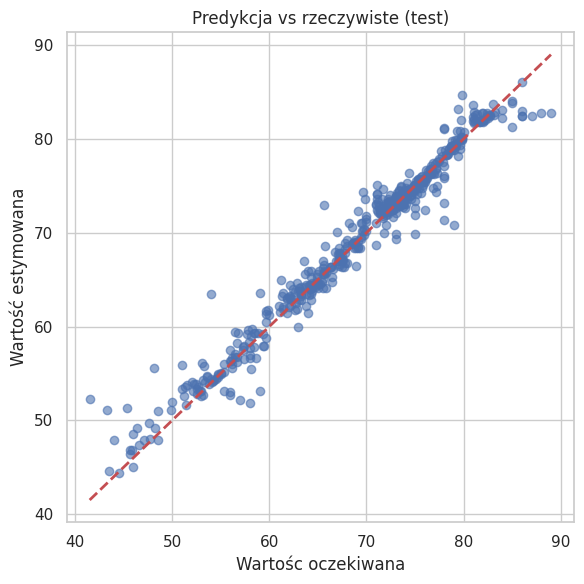

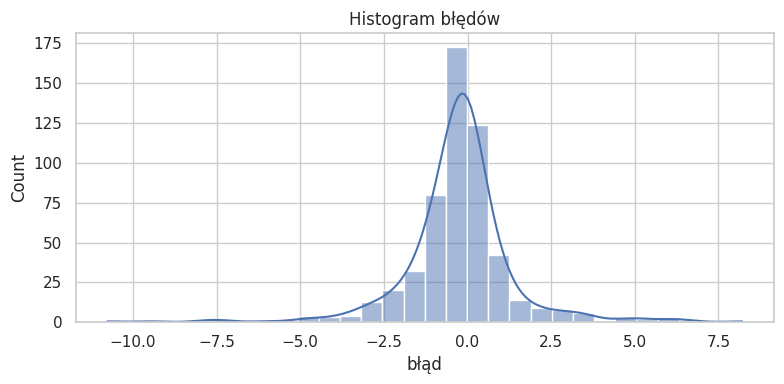

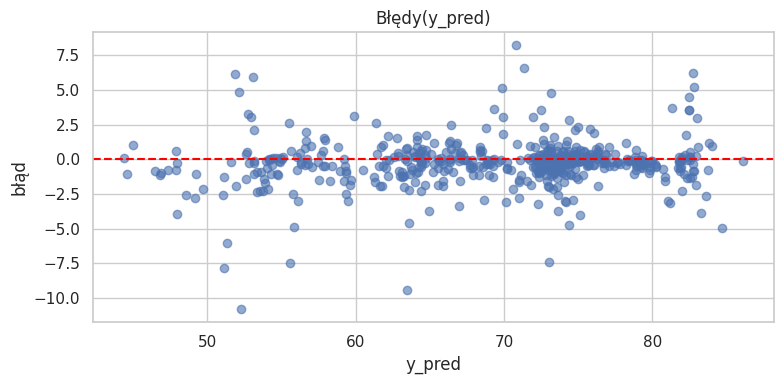

Błędy: średnia= -0.2549474515249566 std= 1.685284424517858


In [37]:
best_interpolation.fit(X_train_t_interpolation, y_train_interpolation)
y_pred = best_interpolation.predict(X_test_t_interpolation)

errors = y_test_interpolation - y_pred

# Wykres 1
plt.figure(figsize=(6, 6))
plt.scatter(y_test_interpolation, y_pred, alpha=0.6)
min_v = min(y_test_interpolation.min(), y_pred.min())
max_v = max(y_test_interpolation.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], "r--", linewidth=2)
plt.xlabel("Wartośc oczekiwana")
plt.ylabel("Wartość estymowana")
plt.title("Predykcja vs rzeczywiste (test)")
plt.tight_layout()
plt.show()

# Wykres 2
plt.figure(figsize=(8, 4))
sns.histplot(errors, kde=True, bins=30)
plt.title("Histogram błędów")
plt.xlabel("błąd")
plt.tight_layout()
plt.show()

# Wykres 3
plt.figure(figsize=(8, 4))
plt.scatter(y_pred, errors, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Błędy(y_pred)")
plt.xlabel("y_pred")
plt.ylabel("błąd")
plt.tight_layout()
plt.show()

print("Błędy: średnia=", float(np.mean(errors)), "std=", float(np.std(errors)))

Jak można zobaczyć na pierwszym wykresie oraz histogramie większość błędów popełnianych przez nasz model oscyluje w okolicach 0-1. Jest to bardzo dobry znak. Na wykresach możemy również zaobserwować kilka wartości odstających, które przy pesymistycznym losowaniu w metrykach mogą zniekształcać znacząco mierzone metryki. Jak widać na histogramie nasz model wykazuje większą tendencję do zawyżania przeiwdywanej długości życia niż jej zaniżania, jednakże nadal nie jest to zjawisko częste. Ponadto nasz model nie ma tendencji do uzależniania błędów od poziomu predykcji. Na wykresie 3 punkty są w miarę równomiernie rozmieszczone na całym wykresie. Niska średnia błędów potwierdza wnioski wyniesione z obserwacji wykresów.

# 13. Ważność cech w modelu drzewa decyzyjnego

W przeciwieństwie do modeli liniowych drzewa decyzyjne nie zawierają współczynników pokazujących czy dana cecha ma dodatni czy ujemny wpływ na model albo jak silny on jest. W drzewach możemy mówić o współczynnikach określających jak bardzo dana cecha jest przydatna, a dokładniej jak bardzo wpływa ona na redukcję błędu w modelu. W tym punkcie przyjrzymy się tym współczynnikom w naszym najlepszym dotychczas modelu.

In [42]:
pd.DataFrame([best_interpolation.feature_importances_], columns=selected_features_backward)

,Status,Adult Mortality,BMI,Polio,Diphtheria,HIV/AIDS,GDP,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,0.093894,0.009326,0.006796,0.004713,0.101023,0.017871,0.007419,0.012277,0.736212,0.010123,0.000346


Jak możemy zobaczyć ogromnie istotną cechą dla naszego modelu jest 'thinness 5-9 years', która odpowiada za prawie 74% redukcji błędów. Do pozostałych najważniejszych cech należą również 'Status' i 'Diphtheria' z których każda odpowiada za prawie 10% redukcji błędów. Co ciekawe cecha o największej korelacji 'Schooling' jest najmniej istotna dla naszego modelu. Być może jest to spowodowane jej charakterystyką - dla danego kraju na przestrzeni lat zazwyczaj pozostaje bez zmian.

Sytuacja którą obserwujemy z cechą 'thinness 5-9 years' jest jednak jednak dosyć niebezpieczna. Jakiekolwiek błędy związane z tą jedną cechą czy też związany z nią szum wpłynie bardzo mocno i negatywnie na nasz model. Szczególnie, że korelacja tej cechy nie wyróżnia się na tle innych, nieco pominiętych cech przez nasz model.

# 14. Sprawdzenie uogólniania: podział po krajach (Country-holdout)

W danych mamy układ kraj–rok. Przy zwykłym losowym podziale wierszy ten sam kraj zwykle trafia i do zbioru trenigowego i do testowego, co może wprowadzać dodatkowe obciążenie ze względu na "znajomość" danego kraju przez model.

Z tego względu w tym punkcie przeprowadzamy obrębny od poprzedniego test generalizacji. Składa się on z następujących etapów:
- losujemy ~80% krajów do zbioru treningowego, a pozostałe kraje przenosimy do zbioru testowego,
- trenujemy model na wierszach z krajów-treningowych,
- sprawdzamy metryki na krajach ze zbioru testowego

Pomimo tego, że w tym punkcie używamy cechy Contry pragniemy zaznaczyć, że służy ona tu tylko do dokonania podziału.

In [39]:
_df = df_interpolation.copy()

y_all = _df["Life expectancy"]

X_all = _df.drop(columns=["Life expectancy", "Country"]).reset_index(drop=True)

#country uzywane tylko do podzialu
groups = _df["Country"].reset_index(drop=True)

unique_countries = groups.unique()
rng = np.random.RandomState(RANDOM_STATE)
rng.shuffle(unique_countries)

cut = int(0.8 * len(unique_countries))
train_countries = set(unique_countries[:cut])
is_train = groups.isin(train_countries)

X_train_c = X_all.loc[is_train].reset_index(drop=True)
y_train_c = y_all.loc[is_train].reset_index(drop=True)
X_test_c = X_all.loc[~is_train].reset_index(drop=True)
y_test_c = y_all.loc[~is_train].reset_index(drop=True)

print("Podsumowanie podziału:")
print("- wymiar zbioru treningowego:", X_train_c.shape, "\nwymiar zbioru testowego:", X_test_c.shape)
print("- liczba krajów treningowych:", len(train_countries), "\nliczba krajów testowych:", len(unique_countries) - len(train_countries))

X_train_c, X_test_c = prepare_X_t(X_train_c, X_test_c)

evaluate_and_select_best(X_train_c, X_test_c, y_train_c, y_test_c, "Interpolacja 13 cech")
indexes = [X_all.columns.get_loc(col) for col in selected_features_backward]
evaluate_and_select_best(X_train_c[:,indexes], X_test_c[:,indexes], y_train_c, y_test_c, "Interpolacja wybór cech")
print("\n Najlepszy dotychczas model:")
evaluate_estimator(best_interpolation, X_train_c[:,indexes], X_test_c[:,indexes], y_train_c, y_test_c, True)

Podsumowanie podziału:
- wymiar zbioru treningowego: (2176, 13) 
wymiar zbioru testowego: (560, 13)
- liczba krajów treningowych: 136 
liczba krajów testowych: 35


Sposób uzupełniania:Interpolacja 13 cech


,model,MAE,RMSE,R2
3,"(DecisionTreeRegressor(max_depth=20, max_featu...",2.082523,2.919355,0.901646
1,"LassoCV(alphas=100, cv=5, random_state=42)",2.914288,3.836524,0.830139
2,"RidgeCV(alphas=array([1.00000000e-03, 4.641588...",3.028122,3.940122,0.820841
0,LinearRegression(),3.050320,4.018494,0.813643


Najlepszy wg RMSE: RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)


Sposób uzupełniania:Interpolacja wybór cech


,model,MAE,RMSE,R2
3,"(DecisionTreeRegressor(max_depth=20, max_featu...",2.055501,2.875758,0.904562
1,"LassoCV(alphas=100, cv=5, random_state=42)",2.960954,3.909304,0.823633
2,"RidgeCV(alphas=array([1.00000000e-03, 4.641588...",3.068512,4.026496,0.812900
0,LinearRegression(),3.092638,4.107125,0.805332


Najlepszy wg RMSE: RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)

 Najlepszy dotychczas model:


{'model': RandomForestRegressor(max_depth=25, n_estimators=300, random_state=42),
 'MAE': 2.071735678281857,
 'RMSE': np.float64(2.8990056006346596),
 'R2': 0.9030123291542305}

W przypadku modeli liniowych wyniki uzyskane w tym teście są gorsze od tych uzyskanych dla zbioru w którym jeden kraj mógł znaleźć się zarówno w danych testowych jak i treningowych. Lepiej z tymi zmianami poradziły sobie modele Ridge i Lasso dla których wzrost błędu nie jest aż tak duży. Najgorzej wśród modeli liniowych test przeszedł model LinearRegression. W przypadku testów na zbiorze z wybranymi cechami modele liniowe wykazują większy błąd niż dla zbioru ze wszystkimi cechami. Jest to naturalne zjawisko ze względu na sposób doboru cech - minimalizację błędu dla drzewa decyzyjnego.

W przypadku modelu nieliniowego - drzewa decyzyjnego możemy zauwazyć znaczny wzrost błędów we wszystkich metrykach względem poprzednich testów. Dla RMSE jest to około 1, a dla MAE około 1.05. Nasz dotychczasowy najlepszy model wypadł gorzej od modelu niedostrojonego. Różnice te nie są jednak bardzo duże. Wynik ten pokazuje, że nasz model oparty na drzewach decyzyjnych nie reaguje najlepiej na generalizację opartą na dodaniu nowych krajów do zbioru. Należy jednak podkreślić, iż nadal jest on najlepszym modelem spośród wszystkich badanych. W zastosowaniach praktycznych wada ta może nie mieć aż takiego znaczenia ze względu na ściśle określony i ograniczony zbiór krajów na świecie.

## 15. Przykładowe predykcje modelu

Poniżej przedstawiamy przykładowe predykcje naszego modelu. Indeksy są za każdym razem generowane losowo, dlatego przy każdym uruchomieniu można zobaczyć inne wyniki.

In [155]:
random_indexes = np.random.randint(low=0, high=len(X_test_t_interpolation), size=10)
y_pred = best_interpolation.predict(X_test_t_interpolation[random_indexes,:])
pd.DataFrame(np.array([y_pred,
            y_test_interpolation.iloc[random_indexes],
            (y_pred-y_test_interpolation.iloc[random_indexes])]).T,
            columns=['y_pred', 'y_test', 'błąd'])

,y_pred,y_test,błąd
0,62.4545,58.4,4.0545
1,82.4840,82.7,-0.2160
2,81.5160,81.2,0.3160
3,81.5985,82.0,-0.4015
4,73.2675,73.0,0.2675
5,82.4260,82.4,0.0260
6,54.5085,56.0,-1.4915
7,64.1050,64.0,0.1050
8,71.4760,73.8,-2.3240
9,77.5305,77.9,-0.3695


# 16. Wnioski do sprawozdania 
W ramach podsumowania naszego sprawozdania możemy wyciągnąć następujące wnioski:
- **początkowa redukcja braków danych** poprzez usunięcie słabo skorelowanych cech i uzupełnienie GDP danymi z innego zbioru **pozwoliła na uzupełnienie większości braków** przez co prawdopodobnie różnice pomiędzy sposobami uzupełnienia danych nie były tak mocno widoczne,
- w porównaniu do autouzupełnienia i mediany **interpolacja jest najlepszym sposobem uzupełniania brakujących danych** co było bardzo widoczne w modelach liniowych
- **model oparty na drzewach decyzyjnych** radził sobie o wiele lepiej w predykcji długości życia od modeli liniowych, dlatego **rekomendujemy go do dalszego użytku**,
- metryka $R^2$ wykazuje, że model ten jest o prawie **96% lepszy** od zwykłej średniej z cech,
- **dostrojenie parametrów modelu** pozwala na zmniejszenie błędów jakie model popełnia na naszym zbiorze testowym i treningowym, jednak **może prowadzić do pogorszenia wyników** w przypadku zmiany sposobu losowania co było widoczne w przypadku podziału wg krajów,
- w przypadku próby obniżenia złożoności modelu poprzez ograniczenie liczby cech wchodzących w jego skład **należy uważać tak, aby model z jednej strony nie uzależniał się** od jakieś jednej konkretnej cechy (co może mieć negatywny wpływ np. w przypadku gdy jej pomiar obarczony będzie jakimś nowym błędem), **ale też nie posiadał za małej ilości informacji**,
- **test generalizacji naszego modelu na zbiorze testowym wypadł bardzo pozytywnie** - błędy okazały się być niższe niż w przypadku predykcji na zbiorze testowym, jednakże **jeśli pogrupowaliśmy zbiór wedlug krajów wyniki naszego modelu bardzo mocno się zmieniły**, takie różnice nie były obserwowalne w modelach liniowych; świadczy to o dużej wrażliwości modelu na zmiany w danych, co może być jego negatywną stroną (brak stabilności),
- niestety podgląd współczynników modelu wykazał **znaczne uzależnienie się modelu od jednej zmiennej**.

Model oparty na drzewach decyzyjnych w naszym zastosowaniu jest bardzo ciekawym rozwiązaniem. Jak pokazaliśmy w sprawozdaniu nie jest ono jednak pozbawione wad. W przypadku rzeczywistych aplikacji należy rozszerzyć przedstawione tutaj próby jego optymalizacji jak również zbadać jego zachowanie na nowych, nieznanych wcześniej danych. Uważamy, że wytrenowany w tym sprawozdaniu model nadaje się z powodzeniem do wstępnych aplikacji i przeprowadzania dalszych badań. Pomimo swoich niedociągnięć i tak jest on o wiele lepszy w naszym zastosowaniu od jego liniowych konkurentów.

